In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 联合建模数据
df_lianhe = pd.read_csv('lianhe_data.csv')

In [4]:
df_lianhe.head(2)

,user_id,apply_date,label,s1,s2,s3,s4,s5,s6,s7,...,s38,s39,s40,s41,s42,s43,s44,s45,s46,s47
0,uid1,2021-07-04,0,0.0,4.0,0.0,0.0,0.0,7.0,1.0,...,0.0,5.0,4.0,7.0,6.0,5.0,0.0,4.0,6.0,0.0
1,uid2,2021-07-04,1,1.0,8.0,0.0,1.0,1.0,9.0,1.0,...,0.0,5.0,5.0,5.0,6.0,5.0,1.0,8.0,4.0,0.0


In [5]:
# 划分出训练数据和OOT数据，OOT上的KS作为模型的评价标准

data_lianhe = df_lianhe[df_lianhe.apply_date<'2021-07-08']
oot_lianhe = df_lianhe[df_lianhe.apply_date>='2021-07-08']

In [6]:
# 训练数据按8:2划分出训练集和验证集
train_lianhe = data_lianhe.sample(frac=0.8,random_state=2011)
valid_lianhe = data_lianhe[~(data_lianhe.user_id.isin(train_lianhe.user_id))]

In [7]:
# 定义计算KS的函数
def cal_score_ks(df,score_col,target):
    
    total_bad = df[target].sum()
    total_good = df[target].count()-total_bad
    score_list = list(df[score_col])
    target_list = list(df[target])
    items = sorted(zip(score_list,target_list),key=lambda x:x[0]) 
    step = (max(score_list)-min(score_list))/200 
    
    score_bin=[] 
    good_rate=[] 
    bad_rate=[] 
    ks_list = [] 
    for i in range(1,201):
        idx = min(score_list)+i*step 
        score_bin.append(idx) 
        target_bin = [x[1] for x in items if x[0]<idx]  
        bad_num = sum(target_bin)
        good_num = len(target_bin)-bad_num 
        goodrate = good_num/total_good 
        badrate = bad_num/total_bad
        ks = abs(goodrate-badrate) 
        good_rate.append(goodrate)
        bad_rate.append(badrate)
        ks_list.append(ks)
        
    ks = max(ks_list)
    
    return ks

In [8]:
# 定义lightgbm训练的函数
def get_lgb_model(train_data,valid_data,eta,num_leaves,min_child_samples,colsample_bytree,stop_rounds):
    
    lgb_x_train = train_data.drop(['user_id','apply_date','label'],axis=1)
    lgb_y_train = train_data['label']
    lgb_x_valid = valid_data.drop(['user_id','apply_date','label'],axis=1)
    lgb_y_valid = valid_data['label']

    lgb_params={'learning_rate':eta,
                 'n_estimators':10000,
                 'num_leaves':num_leaves,
                 'min_child_samples':min_child_samples,
                 'subsample':0.9,
                 'colsample_bytree':colsample_bytree}
    
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(lgb_x_train,
                  lgb_y_train,
                  early_stopping_rounds=stop_rounds,
                  eval_set=[(lgb_x_train,lgb_y_train),(lgb_x_valid,lgb_y_valid)],
                  eval_metric='auc',
                  verbose=50)
    
    imp_df = pd.DataFrame({'col':lgb_x_train.columns,
                       'imp':model.feature_importances_}).sort_values('imp',ascending=0).reset_index(drop=1)
    
    model_col = list(lgb_x_train.columns)
    
    return model,model_col

In [9]:
# 融合模型训练
model_ronghe,model_col_ronghe = get_lgb_model(train_ronghe,valid_ronghe,0.05,6,50,0.8,100)

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.72153	training's binary_logloss: 0.28904	valid_1's auc: 0.648873	valid_1's binary_logloss: 0.302653
[100]	training's auc: 0.74695	training's binary_logloss: 0.280625	valid_1's auc: 0.650445	valid_1's binary_logloss: 0.302768
[150]	training's auc: 0.76967	training's binary_logloss: 0.274286	valid_1's auc: 0.648606	valid_1's binary_logloss: 0.303467
Early stopping, best iteration is:
[65]	training's auc: 0.728607	training's binary_logloss: 0.286212	valid_1's auc: 0.649983	valid_1's binary_logloss: 0.302507


In [10]:
# 融合模型OOT的KS计算
oot_pre_ronghe = model_ronghe.predict_proba(oot_ronghe.loc[:,model_col_ronghe])[:,1]
oot_ronghe_score = oot_ronghe.copy()
oot_ronghe_score['ronghe_score'] = [round(300-100*math.log(x/(1-x))) for x in oot_pre_ronghe]
print('融合建模 oot ks')
print(cal_score_ks(oot_ronghe_score,'ronghe_score','label'))

融合建模 oot ks
0.257074997742874


In [11]:
# 联合建模的模型训练
model_lianhe,model_col_lianhe = get_lgb_model(train_lianhe,valid_lianhe,0.05,8,50,0.8,40)

Training until validation scores don't improve for 40 rounds
[50]	training's auc: 0.717941	training's binary_logloss: 0.290681	valid_1's auc: 0.63122	valid_1's binary_logloss: 0.304138
[100]	training's auc: 0.752608	training's binary_logloss: 0.280897	valid_1's auc: 0.645034	valid_1's binary_logloss: 0.301637
[150]	training's auc: 0.779282	training's binary_logloss: 0.273307	valid_1's auc: 0.64829	valid_1's binary_logloss: 0.30074
[200]	training's auc: 0.801145	training's binary_logloss: 0.266878	valid_1's auc: 0.649048	valid_1's binary_logloss: 0.300674
Early stopping, best iteration is:
[181]	training's auc: 0.792868	training's binary_logloss: 0.269213	valid_1's auc: 0.650027	valid_1's binary_logloss: 0.300526


In [12]:
# 联合建模计算验证集KS，后面用CV方法输出train的模型分时要做参考
valid_pre_lianhe = model_lianhe.predict_proba(valid_lianhe.loc[:,model_col_lianhe])[:,1]
valid_lianhe_score = valid_lianhe.copy()
valid_lianhe_score['lianhe_score'] = [round(300-100*math.log(x/(1-x))) for x in valid_pre_lianhe]
print('联合建模 验证集 ks')
print(cal_score_ks(valid_lianhe_score,'lianhe_score','label'))

联合建模 验证集 ks
0.2344313349703539


In [13]:
# 联合模型OOT的KS计算
oot_pre_lianhe = model_lianhe.predict_proba(oot_lianhe.loc[:,model_col_lianhe])[:,1]
oot_lianhe_score = oot_lianhe.copy()
oot_lianhe_score['lianhe_score'] = [round(300-100*math.log(x/(1-x))) for x in oot_pre_lianhe]
print('联合建模 oot ks')
print(cal_score_ks(oot_lianhe_score,'lianhe_score','label'))

联合建模 oot ks
0.21627780997620555


In [14]:
# 用K折将联合建模的训练数据data_lianhe划分成5部分
from sklearn.model_selection import KFold
kf_split = KFold(n_splits = 5, shuffle=True, random_state=2022)

# 每部分的train和valid的索引
train_index_list=[]
valid_index_list=[]
for train_index,valid_index in kf_split.split(data_lianhe):
    train_index_list.append(train_index)
    valid_index_list.append(valid_index)

In [15]:
# 定义计算valid模型分的函数
def get_valid_score(model,valid_data,model_col,score_col):

    print('valid ks:')
    valid_data2 = valid_data.copy()
    valid_pre = model.predict_proba(valid_data2.loc[:,model_col])[:,1]
    valid_data2[score_col] = [round(300-100*math.log(x/(1-x))) for x in valid_pre]
    print(cal_score_ks(valid_data2,score_col,'label'))
    
    return valid_data2

# 定义比较CV的valid分布 和 联合建模模型valid分布 的函数，两者的分布要尽量一致，这样CV的5个模型能近似和联合建模模型一致
def plot_score(data1,data2,score_col):
    
    sns.kdeplot(data1[score_col],label='1')
    sns.kdeplot(data2[score_col],label='2')
    plt.legend()
    plt.show()

In [16]:
# 训练第一个CV模型，通过参数调整让CV valid的KS和模型分分布与 联合建模模型的valid趋于一致
lianhe_train1 = data_lianhe.iloc[train_index_list[0]]
lianhe_valid1 = data_lianhe.iloc[valid_index_list[0]]

lianhe_model1,lianhe_model_col1 = get_lgb_model(lianhe_train1,lianhe_valid1,0.05,8,50,0.9,40)
lianhe_valid_score1 = get_valid_score(lianhe_model1,lianhe_valid1,lianhe_model_col1,'lianhe_score')

Training until validation scores don't improve for 40 rounds
[50]	training's auc: 0.723632	training's binary_logloss: 0.289213	valid_1's auc: 0.606006	valid_1's binary_logloss: 0.308088
[100]	training's auc: 0.750929	training's binary_logloss: 0.279604	valid_1's auc: 0.615097	valid_1's binary_logloss: 0.307294
[150]	training's auc: 0.779015	training's binary_logloss: 0.27185	valid_1's auc: 0.620272	valid_1's binary_logloss: 0.306801
[200]	training's auc: 0.800856	training's binary_logloss: 0.265141	valid_1's auc: 0.624589	valid_1's binary_logloss: 0.306412
Early stopping, best iteration is:
[187]	training's auc: 0.795376	training's binary_logloss: 0.266879	valid_1's auc: 0.625148	valid_1's binary_logloss: 0.306296
valid ks:
0.20730049195395733


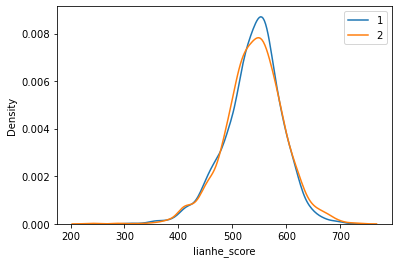

In [17]:
plot_score(valid_lianhe_score,lianhe_valid_score1,'lianhe_score')

In [18]:
# 训练第二个CV模型，通过参数调整让CV valid的KS和模型分分布与 联合建模模型的valid趋于一致
lianhe_train2 = data_lianhe.iloc[train_index_list[1]]
lianhe_valid2 = data_lianhe.iloc[valid_index_list[1]]

lianhe_model2,lianhe_model_col2 = get_lgb_model(lianhe_train2,lianhe_valid2,0.05,8,50,0.8,40)
lianhe_valid_score2 = get_valid_score(lianhe_model2,lianhe_valid2,lianhe_model_col2,'lianhe_score')

Training until validation scores don't improve for 40 rounds
[50]	training's auc: 0.718617	training's binary_logloss: 0.291613	valid_1's auc: 0.629731	valid_1's binary_logloss: 0.299125
[100]	training's auc: 0.750225	training's binary_logloss: 0.281822	valid_1's auc: 0.643059	valid_1's binary_logloss: 0.297591
[150]	training's auc: 0.776109	training's binary_logloss: 0.274291	valid_1's auc: 0.647829	valid_1's binary_logloss: 0.29699
Early stopping, best iteration is:
[158]	training's auc: 0.782175	training's binary_logloss: 0.27308	valid_1's auc: 0.648754	valid_1's binary_logloss: 0.29686
valid ks:
0.21702309895998562


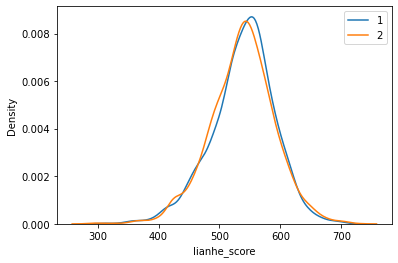

In [19]:
plot_score(valid_lianhe_score,lianhe_valid_score2,'lianhe_score')

In [20]:
# 训练第三个CV模型，通过参数调整让CV valid的KS和模型分分布与 联合建模模型的valid趋于一致
lianhe_train3 = data_lianhe.iloc[train_index_list[2]]
lianhe_valid3 = data_lianhe.iloc[valid_index_list[2]]

lianhe_model3,lianhe_model_col3 = get_lgb_model(lianhe_train3,lianhe_valid3,0.05,10,50,0.7,50)
lianhe_valid_score3 = get_valid_score(lianhe_model3,lianhe_valid3,lianhe_model_col3,'lianhe_score')

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.728885	training's binary_logloss: 0.290447	valid_1's auc: 0.65043	valid_1's binary_logloss: 0.293089
[100]	training's auc: 0.767931	training's binary_logloss: 0.279009	valid_1's auc: 0.66213	valid_1's binary_logloss: 0.290145
[150]	training's auc: 0.799134	training's binary_logloss: 0.270263	valid_1's auc: 0.664552	valid_1's binary_logloss: 0.289299
[200]	training's auc: 0.824574	training's binary_logloss: 0.262391	valid_1's auc: 0.663541	valid_1's binary_logloss: 0.289093
Early stopping, best iteration is:
[151]	training's auc: 0.799849	training's binary_logloss: 0.27009	valid_1's auc: 0.665001	valid_1's binary_logloss: 0.289216
valid ks:
0.24336119241165455


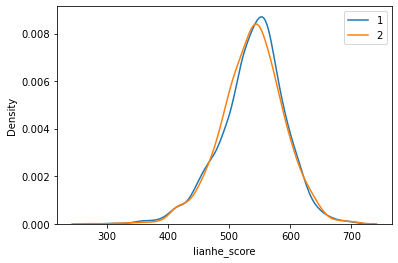

In [21]:
plot_score(valid_lianhe_score,lianhe_valid_score3,'lianhe_score')

In [22]:
# 训练第四个CV模型，通过参数调整让CV valid的KS和模型分分布与 联合建模模型的valid趋于一致
lianhe_train4 = data_lianhe.iloc[train_index_list[3]]
lianhe_valid4 = data_lianhe.iloc[valid_index_list[3]]

lianhe_model4,lianhe_model_col4 = get_lgb_model(lianhe_train4,lianhe_valid4,0.05,10,50,0.7,100)
lianhe_valid_score4 = get_valid_score(lianhe_model4,lianhe_valid4,lianhe_model_col4,'lianhe_score')

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.738462	training's binary_logloss: 0.287963	valid_1's auc: 0.631609	valid_1's binary_logloss: 0.301685
[100]	training's auc: 0.777827	training's binary_logloss: 0.275977	valid_1's auc: 0.637491	valid_1's binary_logloss: 0.299739
[150]	training's auc: 0.80768	training's binary_logloss: 0.266946	valid_1's auc: 0.63622	valid_1's binary_logloss: 0.299937
[200]	training's auc: 0.829356	training's binary_logloss: 0.259316	valid_1's auc: 0.6356	valid_1's binary_logloss: 0.300292
Early stopping, best iteration is:
[114]	training's auc: 0.786435	training's binary_logloss: 0.27326	valid_1's auc: 0.639202	valid_1's binary_logloss: 0.29951
valid ks:
0.1992685452845921


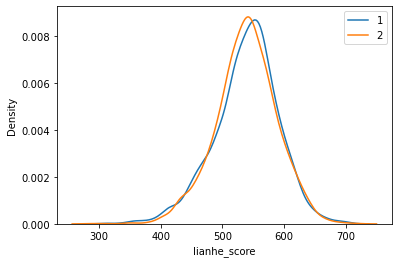

In [23]:
plot_score(valid_lianhe_score,lianhe_valid_score4,'lianhe_score')

In [24]:
# 训练第五个CV模型，通过参数调整让CV valid的KS和模型分分布与 联合建模模型的valid趋于一致
lianhe_train5 = data_lianhe.iloc[train_index_list[4]]
lianhe_valid5 = data_lianhe.iloc[valid_index_list[4]]

lianhe_model5,lianhe_model_col5 = get_lgb_model(lianhe_train5,lianhe_valid5,0.05,8,50,0.8,50)
lianhe_valid_score5 = get_valid_score(lianhe_model5,lianhe_valid5,lianhe_model_col5,'lianhe_score')

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.716132	training's binary_logloss: 0.289829	valid_1's auc: 0.653969	valid_1's binary_logloss: 0.308539
[100]	training's auc: 0.750567	training's binary_logloss: 0.280499	valid_1's auc: 0.659497	valid_1's binary_logloss: 0.305998
[150]	training's auc: 0.778153	training's binary_logloss: 0.272981	valid_1's auc: 0.660508	valid_1's binary_logloss: 0.304755
[200]	training's auc: 0.799047	training's binary_logloss: 0.266465	valid_1's auc: 0.66133	valid_1's binary_logloss: 0.303939
Early stopping, best iteration is:
[196]	training's auc: 0.798161	training's binary_logloss: 0.266919	valid_1's auc: 0.662137	valid_1's binary_logloss: 0.303872
valid ks:
0.24448153338877288


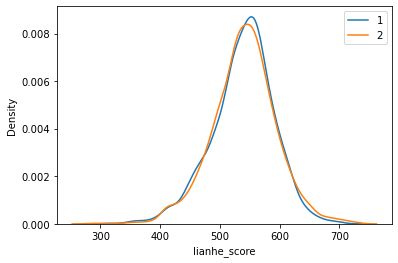

In [25]:
plot_score(valid_lianhe_score,lianhe_valid_score5,'lianhe_score')

In [26]:
# 合并每个CV valid的lianhe_score和OOT的lianhe_score
lianhe_score_df = pd.concat([lianhe_valid_score1[['user_id','apply_date','lianhe_score']],
                            lianhe_valid_score2[['user_id','apply_date','lianhe_score']],
                            lianhe_valid_score3[['user_id','apply_date','lianhe_score']],
                            lianhe_valid_score4[['user_id','apply_date','lianhe_score']],
                            lianhe_valid_score5[['user_id','apply_date','lianhe_score']],
                            oot_lianhe_score[['user_id','apply_date','lianhe_score']]
                            ],axis=0)
lianhe_score_df.shape

(19780, 3)

In [28]:
# 将lianhe_score加到融合模型的train，valid，OOT中去
train_ronghe2 = pd.merge(train_ronghe,lianhe_score_df,on=['user_id','apply_date'])
valid_ronghe2 = pd.merge(valid_ronghe,lianhe_score_df,on=['user_id','apply_date'])
oot_ronghe2 = pd.merge(oot_ronghe,lianhe_score_df,on=['user_id','apply_date'])

In [29]:
# 开发model_ronghe2
model_ronghe2,model_col_ronghe2 = get_lgb_model(train_ronghe2,valid_ronghe2,0.05,6,50,0.9,100)

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.730887	training's binary_logloss: 0.284186	valid_1's auc: 0.66399	valid_1's binary_logloss: 0.298648
[100]	training's auc: 0.75681	training's binary_logloss: 0.275427	valid_1's auc: 0.668155	valid_1's binary_logloss: 0.298206
[150]	training's auc: 0.775711	training's binary_logloss: 0.269124	valid_1's auc: 0.667716	valid_1's binary_logloss: 0.298963
Early stopping, best iteration is:
[91]	training's auc: 0.752959	training's binary_logloss: 0.276723	valid_1's auc: 0.667426	valid_1's binary_logloss: 0.298169


In [30]:
# 计算model_ronghe2的OOT KS
oot_pre_ronghe2 = model_ronghe2.predict_proba(oot_ronghe2.loc[:,model_col_ronghe2])[:,1]
oot_ronghe_score2 = oot_ronghe2.copy()
oot_ronghe_score2['ronghe_score2'] = [round(300-100*math.log(x/(1-x))) for x in oot_pre_ronghe2]
cal_score_ks(oot_ronghe_score2,'ronghe_score2','label')

0.2868413924865374